In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# 1. Charger les données
df = pd.read_csv('../data/portfolios.csv')
# 2. Identifier les colonnes
# Supposons que 'YM' est à l'index 0. Les 30 portefeuilles vont de l'index 1 à 30 inclus.
portfolio_cols = df.columns[1:31]

# Extraire les rendements des portfolios et les facteurs
R = df[portfolio_cols]
factors = df[['DOL', 'CAR']]

# =====================================================================
# ÉTAPE 1 : Séries Temporelles - Estimer les quantités de risque (Bêtas)
# =====================================================================
# On ajoute une constante aux facteurs pour la régression
X_ts = sm.add_constant(factors)
betas = []

for port in portfolio_cols:
    # Régression du portfolio sur le temps
    model_ts = sm.OLS(R[port], factors).fit()

    # On sauvegarde les bêtas de chaque portfolio
    betas.append({
        'Portfolio': port,
        'Beta_DOL': model_ts.params['DOL'],
        'Beta_CAR': model_ts.params['CAR']
    })

# Création du DataFrame des Bêtas
betas_df = pd.DataFrame(betas).set_index('Portfolio')

# =====================================================================
# ÉTAPE 2 : Transversale - Estimer les prix du risque (Lambdas)
# =====================================================================
# On utilise les bêtas calculés en étape 1 comme variables explicatives (avec constante)
X_cs = sm.add_constant(betas_df[['Beta_DOL', 'Beta_CAR']])
lambdas_mensuels = []

for t in range(len(df)):
    # Rendements transversaux : les 30 portfolios pour le mois t
    y_cs = R.iloc[t]

    # Régression pour le mois t
    model_cs = sm.OLS(y_cs, X_cs).fit()
    lambdas_mensuels.append(model_cs.params)

# Création du DataFrame des Lambdas indexé par le temps (YM)
lambdas_df = pd.DataFrame(lambdas_mensuels, index=df['YM'])

# =====================================================================
# RÉSULTATS : Moyenne temporelle et Tests Statistiques
# =====================================================================
# Le prix du risque est la moyenne de ces lambdas mensuels
price_of_risk = lambdas_df.mean()

# Calcul de l'erreur standard et de la t-statistique (correction Fama-MacBeth)
T = len(lambdas_df)
std_lambdas = lambdas_df.std()
t_stats = price_of_risk / (std_lambdas / np.sqrt(T))

# Affichage des résultats
print("=== PRIX DU RISQUE (Moyenne des Lambdas) ===")
print(price_of_risk)
print("\n=== T-STATISTIQUES (Significativité) ===")
print(t_stats)

# Optionnel : sauvegarder les lambdas mensuels
# lambdas_df.to_csv("fama_macbeth_lambdas.csv")

=== PRIX DU RISQUE (Moyenne des Lambdas) ===
const       0.006337
Beta_DOL   -0.005116
Beta_CAR    0.005901
dtype: float64

=== T-STATISTIQUES (Significativité) ===
const       3.243504
Beta_DOL   -2.418552
Beta_CAR    6.180897
dtype: float64


In [2]:
import pandas as pd
import statsmodels.api as sm

# 1. Charger les données
df = pd.read_csv('../data/portfolios.csv')

# 2. Identifier les colonnes
# Les 30 portefeuilles vont de l'index 1 à 30 inclus
portfolio_cols = df.columns[1:31]

# Extraire les rendements des portfolios et les facteurs
R = df[portfolio_cols]
factors = df[['DOL', 'CAR']]

# =====================================================================
# ÉTAPE 1 : Séries Temporelles - Estimer les quantités de risque (Bêtas)
# =====================================================================
# SANS INTERCEPT : On utilise directement les facteurs sans constante
X_ts = factors
betas = []

for port in portfolio_cols:
    # Régression OLS du portefeuille sur les facteurs (sans constante)
    model_ts = sm.OLS(R[port], X_ts).fit()

    # On sauvegarde les bêtas estimés pour ce portfolio
    betas.append({
        'Portfolio': port,
        'Beta_DOL': model_ts.params['DOL'],
        'Beta_CAR': model_ts.params['CAR']
    })

# Création du DataFrame des Bêtas
betas_df = pd.DataFrame(betas).set_index('Portfolio')

# Affichage des Bêtas
print(betas_df)

# Optionnel : sauvegarder ce tableau dans un fichier CSV
# betas_df.to_csv('betas_portfolios.csv')

           Beta_DOL  Beta_CAR
Portfolio                    
P1CAR      1.000246 -0.390918
P2CAR      0.946753 -0.142682
P3CAR      0.997285 -0.014577
P4CAR      1.062937  0.041402
P5CAR      1.000246  0.609082
P1VAL      1.048215 -0.135137
P2VAL      1.114092 -0.114981
P3VAL      1.016001 -0.088823
P4VAL      0.888284  0.028516
P5VAL      0.892170  0.382396
P1M1M      1.007298  0.073551
P2M1M      1.029512 -0.033092
P3M1M      1.003020 -0.042081
P4M1M      1.011444 -0.090092
P5M1M      0.951969  0.107973
P1M3M      0.991788  0.076178
P2M3M      1.033160 -0.108747
P3M3M      1.035058 -0.062335
P4M3M      1.008465 -0.041639
P5M3M      0.940560  0.162488
P1M6M      0.997777  0.067114
P2M6M      1.024624 -0.058963
P3M6M      1.080384 -0.091422
P4M6M      1.013647 -0.059119
P5M6M      0.898897  0.161490
P1M1Y      0.994524  0.074824
P2M1Y      1.037318 -0.100966
P3M1Y      1.059046 -0.083138
P4M1Y      1.039282 -0.027975
P5M1Y      0.886733  0.164087


In [3]:
betas_df

,Beta_DOL,Beta_CAR
Portfolio,,
P1CAR,1.000246,-0.390918
P2CAR,0.946753,-0.142682
P3CAR,0.997285,-0.014577
P4CAR,1.062937,0.041402
P5CAR,1.000246,0.609082
P1VAL,1.048215,-0.135137
P2VAL,1.114092,-0.114981
P3VAL,1.016001,-0.088823
P4VAL,0.888284,0.028516


In [4]:
import pandas as pd
import statsmodels.api as sm

# 1. Charger les données
df = pd.read_csv('../data/portfolios.csv')

# Les 30 portefeuilles vont de l'index 1 à 30 inclus
portfolio_cols = df.columns[1:31]

R = df[portfolio_cols]
factors = df[['DOL', 'CAR']]

# =====================================================================
# ÉTAPE 1 : Bêtas (Quantité de risque par portefeuille)
# =====================================================================
betas = []
for port in portfolio_cols:
    model_ts = sm.OLS(R[port], factors).fit()
    betas.append({
        'Portfolio': port,
        'Beta_DOL': model_ts.params['DOL'],
        'Beta_CAR': model_ts.params['CAR']
    })

# DataFrame des Bêtas
resultats_df = pd.DataFrame(betas).set_index('Portfolio')

# =====================================================================
# ÉTAPE 2 : Lambdas (Prix du risque du marché)
# =====================================================================
X_cs = resultats_df[['Beta_DOL', 'Beta_CAR']]
lambdas_mensuels = []

for t in range(len(df)):
    y_cs = R.iloc[t]
    model_cs = sm.OLS(y_cs, X_cs).fit()
    lambdas_mensuels.append(model_cs.params)

lambdas_df = pd.DataFrame(lambdas_mensuels, index=df['YM'])
lambdas_moyens = lambdas_df.mean()

# =====================================================================
# ÉTAPE 3 : Regrouper dans un tableau unique
# =====================================================================
# Ajout des Lambdas (identiques pour tous les portefeuilles)
resultats_df['Lambda_DOL'] = lambdas_moyens['Beta_DOL']
resultats_df['Lambda_CAR'] = lambdas_moyens['Beta_CAR']

# Calcul de la contribution de chaque facteur au rendement du portefeuille (Beta * Lambda)
resultats_df['Rendement_Attendu_DOL'] = resultats_df['Beta_DOL'] * \
    resultats_df['Lambda_DOL']
resultats_df['Rendement_Attendu_CAR'] = resultats_df['Beta_CAR'] * \
    resultats_df['Lambda_CAR']

# Rendement total attendu expliqué par le modèle
resultats_df['Rendement_Total_Attendu'] = resultats_df['Rendement_Attendu_DOL'] + \
    resultats_df['Rendement_Attendu_CAR']

# Affichage des 5 premiers portefeuilles pour vérifier
print(resultats_df.head())

# Sauvegarde des résultats dans un fichier CSV
resultats_df.to_csv('betas_et_lambdas_portfolios.csv')

           Beta_DOL  Beta_CAR  Lambda_DOL  Lambda_CAR  Rendement_Attendu_DOL  \
Portfolio                                                                      
P1CAR      1.000246 -0.390918    0.001195    0.006836               0.001195   
P2CAR      0.946753 -0.142682    0.001195    0.006836               0.001131   
P3CAR      0.997285 -0.014577    0.001195    0.006836               0.001192   
P4CAR      1.062937  0.041402    0.001195    0.006836               0.001270   
P5CAR      1.000246  0.609082    0.001195    0.006836               0.001195   

           Rendement_Attendu_CAR  Rendement_Total_Attendu  
Portfolio                                                  
P1CAR                  -0.002672                -0.001477  
P2CAR                  -0.000975                 0.000156  
P3CAR                  -0.000100                 0.001092  
P4CAR                   0.000283                 0.001553  
P5CAR                   0.004164                 0.005359  



In [5]:
resultats_df.T

Portfolio,P1CAR,P2CAR,P3CAR,P4CAR,P5CAR,P1VAL,P2VAL,P3VAL,P4VAL,P5VAL,...,P1M6M,P2M6M,P3M6M,P4M6M,P5M6M,P1M1Y,P2M1Y,P3M1Y,P4M1Y,P5M1Y
Beta_DOL,1.000246,0.946753,0.997285,1.062937,1.000246,1.048215,1.114092,1.016001,0.888284,0.892170,...,0.997777,1.024624,1.080384,1.013647,0.898897,0.994524,1.037318,1.059046,1.039282,0.886733
Beta_CAR,-0.390918,-0.142682,-0.014577,0.041402,0.609082,-0.135137,-0.114981,-0.088823,0.028516,0.382396,...,0.067114,-0.058963,-0.091422,-0.059119,0.161490,0.074824,-0.100966,-0.083138,-0.027975,0.164087
Lambda_DOL,0.001195,0.001195,0.001195,0.001195,0.001195,0.001195,0.001195,0.001195,0.001195,0.001195,...,0.001195,0.001195,0.001195,0.001195,0.001195,0.001195,0.001195,0.001195,0.001195,0.001195
Lambda_CAR,0.006836,0.006836,0.006836,0.006836,0.006836,0.006836,0.006836,0.006836,0.006836,0.006836,...,0.006836,0.006836,0.006836,0.006836,0.006836,0.006836,0.006836,0.006836,0.006836,0.006836
Rendement_Attendu_DOL,0.001195,0.001131,0.001192,0.001270,0.001195,0.001252,0.001331,0.001214,0.001061,0.001066,...,0.001192,0.001224,0.001291,0.001211,0.001074,0.001188,0.001239,0.001265,0.001242,0.001060
Rendement_Attendu_CAR,-0.002672,-0.000975,-0.000100,0.000283,0.004164,-0.000924,-0.000786,-0.000607,0.000195,0.002614,...,0.000459,-0.000403,-0.000625,-0.000404,0.001104,0.000512,-0.000690,-0.000568,-0.000191,0.001122
Rendement_Total_Attendu,-0.001477,0.000156,0.001092,0.001553,0.005359,0.000329,0.000545,0.000607,0.001256,0.003680,...,0.001651,0.000821,0.000666,0.000807,0.002178,0.001700,0.000549,0.000697,0.001051,0.002181


In [6]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.sandwich_covariance import cov_hac

# 1. Charger les données
df = pd.read_csv('../data/portfolios.csv')
portfolio_cols = df.columns[1:31]
R = df[portfolio_cols]
factors = df[['DOL', 'CAR']]

# =====================================================================
# ÉTAPE 1 : Estimer les Bêtas (AVEC INTERCEPT)
# =====================================================================
# On ajoute une constante aux facteurs pour l'étape temporelle
X_ts = sm.add_constant(factors)
betas = []

for port in portfolio_cols:
    model_ts = sm.OLS(R[port], X_ts).fit()
    betas.append({
        'Portfolio': port,
        'Beta_DOL': model_ts.params['DOL'],
        'Beta_CAR': model_ts.params['CAR']
    })

# Créer un DataFrame pour les Bêtas
betas_df = pd.DataFrame(betas).set_index('Portfolio')

# Exporter les Bêtas modifiés (facultatif)
betas_df.to_csv('betas_portfolios_intercept.csv')

# =====================================================================
# ÉTAPE 2 : Estimer les Lambdas mensuels (AVEC INTERCEPT)
# =====================================================================
# On ajoute une constante aux Bêtas pour l'étape transversale
X_cs = sm.add_constant(betas_df[['Beta_DOL', 'Beta_CAR']])
lambdas_mensuels = []

for t in range(len(df)):
    y_cs = R.iloc[t]
    model_cs = sm.OLS(y_cs, X_cs).fit()
    lambdas_mensuels.append(model_cs.params)

# =====================================================================
# ÉTAPE 3 : Calculer Lambda, T-Stat et P-Value (Méthode Fama-MacBeth)
# =====================================================================
lambdas_mean = lambdas_df.mean()
nw_se = []

for col in lambdas_df.columns:
    ols = sm.OLS(lambdas_df[col], np.ones(T)).fit()
    nw_var = cov_hac(ols)[0, 0]
    nw_se.append(np.sqrt(nw_var))

lambdas_se = pd.Series(nw_se, index=lambdas_df.columns)
t_stats = lambdas_mean / lambdas_se
p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), df=T-1))

fm_stats = pd.DataFrame({
    'Lambda (Prix du risque)': lambdas_mean,
    'NW Std Error': lambdas_se,
    'T-stat': t_stats,
    'P-value': p_values
})

# =====================================================================
# AFFICHAGE DES RÉSULTATS
# =====================================================================
print("\n=== APERÇU DU DATAFRAME DES BÊTAS (AVEC INTERCEPT) ===")
print(betas_df)

print("\n=== STATISTIQUES DES LAMBDAS ===")
print(fm_stats)


=== APERÇU DU DATAFRAME DES BÊTAS (AVEC INTERCEPT) ===
           Beta_DOL  Beta_CAR
Portfolio                    
P1CAR      0.999662 -0.394309
P2CAR      0.947175 -0.140236
P3CAR      0.998028 -0.010262
P4CAR      1.062395  0.038260
P5CAR      0.999662  0.605691
P1VAL      1.047963 -0.136601
P2VAL      1.113137 -0.120521
P3VAL      1.016509 -0.085876
P4VAL      0.887713  0.025201
P5VAL      0.892729  0.385643
P1M1M      1.011182  0.096094
P2M1M      1.032164 -0.017702
P3M1M      1.001796 -0.049184
P4M1M      1.008871 -0.105022
P5M1M      0.947844  0.084037
P1M3M      0.996164  0.101572
P2M3M      1.035368 -0.095934
P3M3M      1.033964 -0.068680
P4M3M      1.006776 -0.051437
P5M3M      0.934730  0.128656
P1M6M      1.001307  0.087601
P2M6M      1.026113 -0.050324
P3M6M      1.079661 -0.095616
P4M6M      1.011858 -0.069496
P5M6M      0.894414  0.135475
P1M1Y      0.997273  0.090780
P2M1Y      1.037362 -0.100711
P3M1Y      1.058429 -0.086718
P4M1Y      1.039240 -0.028220
P5M1Y      0.8

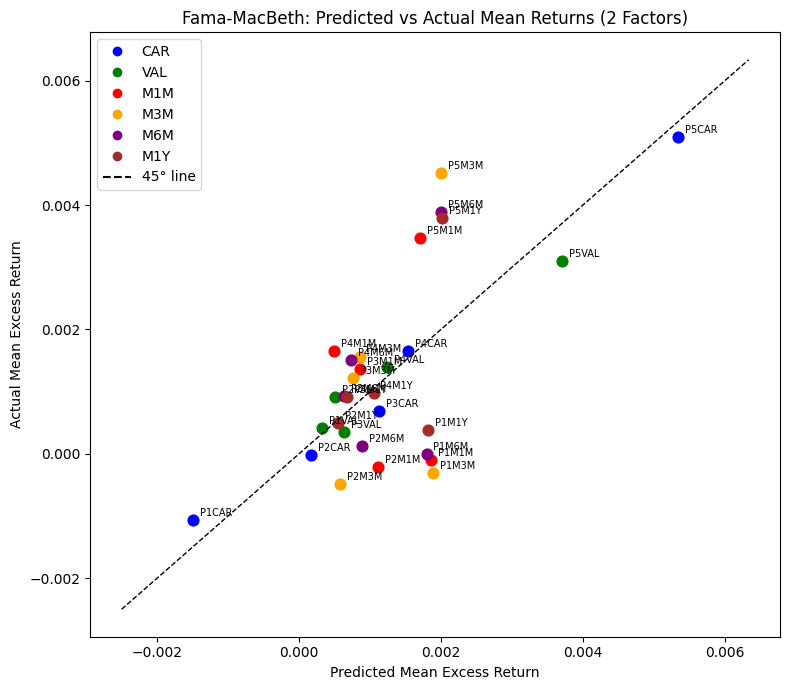

In [7]:
import matplotlib.pyplot as plt

# Actual mean returns
mean_returns = R.mean()

# Predicted returns: lambda_0 + beta_DOL * lambda_DOL + beta_CAR * lambda_CAR + beta_vol * lambda_vol
#lambda_const   = lambdas_mean['const']
lambda_DOL     = lambdas_mean['Beta_DOL']
lambda_CAR     = lambdas_mean['Beta_CAR']
#lambda_vol     = lambdas_mean['Beta_d_log_vol']

predicted = (betas_df['Beta_DOL']     * lambda_DOL
             + betas_df['Beta_CAR']     * lambda_CAR)
             #+ betas_df['Beta_d_log_vol'] * lambda_vol)

# Assign strategy labels for coloring
colors = {
    'CAR': 'blue', 'VAL': 'green',
    'M1M': 'red',  'M3M': 'orange',
    'M6M': 'purple','M1Y': 'brown'
}

fig, ax = plt.subplots(figsize=(8, 7))

for port in portfolio_cols:
    strategy = ''.join([c for c in port if not c.isdigit() and c != 'P'])[:-0 or len(port)]
    # simpler: extract suffix
    suffix = port[2:]  # e.g. 'CAR', 'VAL', 'M1M' etc.
    col = colors.get(suffix, 'black')
    ax.scatter(predicted[port], mean_returns[port], color=col, s=60)
    ax.annotate(port, (predicted[port], mean_returns[port]),
                textcoords='offset points', xytext=(5, 3), fontsize=7)

# 45-degree line
lims = [min(predicted.min(), mean_returns.min()) - 0.001,
        max(predicted.max(), mean_returns.max()) + 0.001]
ax.plot(lims, lims, 'k--', linewidth=1, label='45° line')

ax.set_xlabel('Predicted Mean Excess Return')
ax.set_ylabel('Actual Mean Excess Return')
ax.set_title('Fama-MacBeth: Predicted vs Actual Mean Returns (2 Factors)')
ax.legend(handles=[plt.Line2D([0],[0],color=v,marker='o',linestyle='',label=k)
                   for k,v in colors.items()] +
                  [plt.Line2D([0],[0],color='k',linestyle='--',label='45° line')])
plt.tight_layout()
plt.savefig('predicted_vs_actual_2f.png', dpi=300)
plt.show()

In [8]:
# 1. Pricing errors (alphas) — should be close to zero
pricing_errors = mean_returns - predicted
print("Pricing errors:\n", pricing_errors.round(4))

# 2. Mean Absolute Pricing Error
mape = np.abs(pricing_errors).mean()
print(f"\nMean Absolute Pricing Error: {mape:.6f}")

# 3. Cross-sectional R-squared
ss_res = np.sum(pricing_errors**2)
ss_tot = np.sum((mean_returns - mean_returns.mean())**2)
r2 = 1 - ss_res / ss_tot
print(f"Cross-sectional R²: {r2:.4f}")

Pricing errors:
 P1CAR    0.0004
P2CAR   -0.0002
P3CAR   -0.0004
P4CAR    0.0001
P5CAR   -0.0002
P1VAL    0.0001
P2VAL    0.0004
P3VAL   -0.0003
P4VAL    0.0002
P5VAL   -0.0006
P1M1M   -0.0020
P2M1M   -0.0013
P3M1M    0.0005
P4M1M    0.0012
P5M1M    0.0018
P1M3M   -0.0022
P2M3M   -0.0011
P3M3M    0.0004
P4M3M    0.0007
P5M3M    0.0025
P1M6M   -0.0018
P2M6M   -0.0008
P3M6M    0.0003
P4M6M    0.0008
P5M6M    0.0019
P1M1Y   -0.0014
P2M1Y   -0.0001
P3M1Y    0.0002
P4M1Y   -0.0001
P5M1Y    0.0018
dtype: float64

Mean Absolute Pricing Error: 0.000856
Cross-sectional R²: 0.4643


In [9]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats

# =====================================================================
# PRÉPARATION DES DONNÉES
# =====================================================================
# 1. Charger les données
df = pd.read_csv('../data/portfolios.csv')

# 2. Créer le nouveau facteur : première dérivée du log de la volatilité
df['d_log_vol'] = np.log(df['vol']).diff()

# 3. Supprimer la première ligne qui contient désormais un NaN (à cause du .diff)
df = df.dropna().reset_index(drop=True)

# 4. Identifier les variables
portfolio_cols = df.columns[1:31]
R = df[portfolio_cols]
factors = df[['DOL', 'CAR', 'd_log_vol']]

# =====================================================================
# ÉTAPE 1 : Séries Temporelles - Estimer les quantités de risque (Bêtas)
# =====================================================================
# On ajoute une constante (intercept) aux facteurs
X_ts = sm.add_constant(factors)
betas = []

for port in portfolio_cols:
    # Régression OLS du portefeuille sur les 3 facteurs + constante
    model_ts = sm.OLS(R[port], X_ts).fit()

    # On sauvegarde les bêtas estimés
    betas.append({
        'Portfolio': port,
        'Beta_DOL': model_ts.params['DOL'],
        'Beta_CAR': model_ts.params['CAR'],
        'Beta_d_log_vol': model_ts.params['d_log_vol']
    })

# Création du DataFrame des Bêtas
betas_df = pd.DataFrame(betas).set_index('Portfolio')

# Sauvegarde des bêtas dans un fichier CSV (optionnel)
betas_df.to_csv('betas_portfolios_3_factors.csv')

# =====================================================================
# ÉTAPE 2 : Transversale - Estimer les prix du risque (Lambdas)
# =====================================================================
# On ajoute une constante (intercept) aux Bêtas pour la seconde étape
X_cs = sm.add_constant(betas_df[['Beta_DOL', 'Beta_CAR', 'Beta_d_log_vol']])
lambdas_mensuels = []

for t in range(len(df)):
    y_cs = R.iloc[t]
    model_cs = sm.OLS(y_cs, X_cs).fit()
    lambdas_mensuels.append(model_cs.params)

# Création du DataFrame des Lambdas indexé par le temps
lambdas_df = pd.DataFrame(lambdas_mensuels, index=df['YM'])
T = len(lambdas_df)
# =====================================================================
# ÉTAPE 3 : Statistiques Fama-MacBeth (Significativité)
# =====================================================================
lambdas_mean = lambdas_df.mean()
nw_se = []

for col in lambdas_df.columns:
    ols = sm.OLS(lambdas_df[col], np.ones(T)).fit()
    nw_var = cov_hac(ols)[0, 0]
    nw_se.append(np.sqrt(nw_var))

lambdas_se = pd.Series(nw_se, index=lambdas_df.columns)
t_stats = lambdas_mean / lambdas_se
p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), df=T-1))

fm_stats = pd.DataFrame({
    'Lambda (Prix du risque)': lambdas_mean,
    'NW Std Error': lambdas_se,
    'T-stat': t_stats,
    'P-value': p_values
})

# =====================================================================
# AFFICHAGE DES RÉSULTATS
# =====================================================================
print("=== APERÇU DES BÊTAS (Les 5 premiers) ===")
print(betas_df)

print("\n=== NOUVELLES STATISTIQUES DES LAMBDAS (3 FACTEURS + INTERCEPT) ===")
print(fm_stats)

=== APERÇU DES BÊTAS (Les 5 premiers) ===
           Beta_DOL  Beta_CAR  Beta_d_log_vol
Portfolio                                    
P1CAR      0.999091 -0.398107       -0.000178
P2CAR      0.948447 -0.137830        0.001066
P3CAR      1.002454  0.003466        0.003113
P4CAR      1.057749  0.027899       -0.003718
P5CAR      0.999091  0.601893       -0.000178
P1VAL      1.049092 -0.133387        0.000826
P2VAL      1.117203 -0.110437        0.003140
P3VAL      1.017399 -0.083457        0.000664
P4VAL      0.882886  0.004524       -0.002764
P5VAL      0.890872  0.387471       -0.002148
P1M1M      1.005369  0.078987       -0.004192
P2M1M      1.027095 -0.030843       -0.003853
P3M1M      1.008103 -0.032884        0.004799
P4M1M      1.018385 -0.081537        0.007361
P5M1M      0.943418  0.076847       -0.003838
P1M3M      0.993723  0.098011       -0.002162
P2M3M      1.035198 -0.095924       -0.000179
P3M3M      1.038881 -0.060882        0.004285
P4M3M      1.009695 -0.044612        0

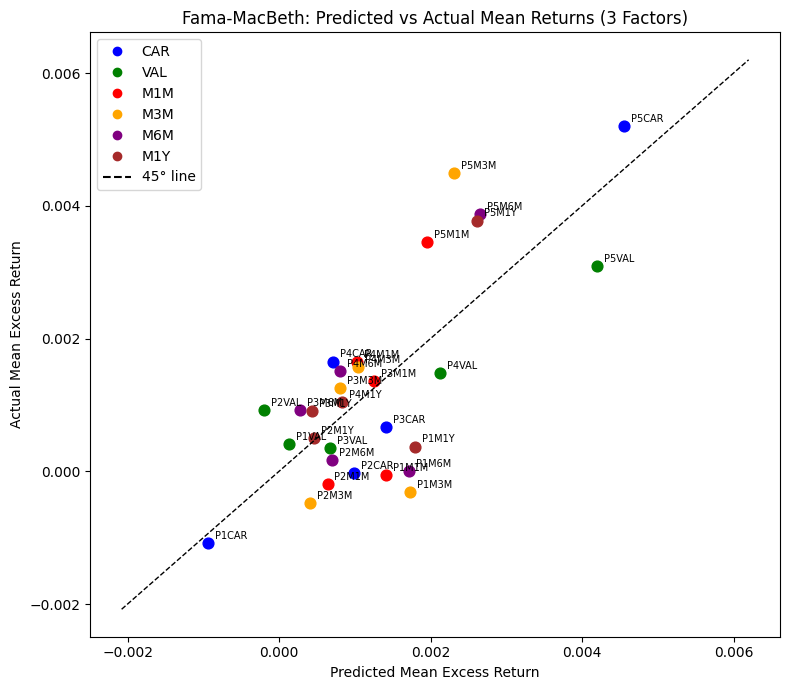

In [10]:
import matplotlib.pyplot as plt

# Actual mean returns
mean_returns = R.mean()

# Predicted returns: lambda_0 + beta_DOL * lambda_DOL + beta_CAR * lambda_CAR + beta_vol * lambda_vol
lambda_const   = lambdas_mean['const']
lambda_DOL     = lambdas_mean['Beta_DOL']
lambda_CAR     = lambdas_mean['Beta_CAR']
lambda_vol     = lambdas_mean['Beta_d_log_vol']

predicted = (lambda_const
             + betas_df['Beta_DOL']     * lambda_DOL
             + betas_df['Beta_CAR']     * lambda_CAR
             + betas_df['Beta_d_log_vol'] * lambda_vol)

# Assign strategy labels for coloring
colors = {
    'CAR': 'blue', 'VAL': 'green',
    'M1M': 'red',  'M3M': 'orange',
    'M6M': 'purple','M1Y': 'brown'
}

fig, ax = plt.subplots(figsize=(8, 7))

for port in portfolio_cols:
    strategy = ''.join([c for c in port if not c.isdigit() and c != 'P'])[:-0 or len(port)]
    # simpler: extract suffix
    suffix = port[2:]  # e.g. 'CAR', 'VAL', 'M1M' etc.
    col = colors.get(suffix, 'black')
    ax.scatter(predicted[port], mean_returns[port], color=col, s=60)
    ax.annotate(port, (predicted[port], mean_returns[port]),
                textcoords='offset points', xytext=(5, 3), fontsize=7)

# 45-degree line
lims = [min(predicted.min(), mean_returns.min()) - 0.001,
        max(predicted.max(), mean_returns.max()) + 0.001]
ax.plot(lims, lims, 'k--', linewidth=1, label='45° line')

ax.set_xlabel('Predicted Mean Excess Return')
ax.set_ylabel('Actual Mean Excess Return')
ax.set_title('Fama-MacBeth: Predicted vs Actual Mean Returns (3 Factors)')
ax.legend(handles=[plt.Line2D([0],[0],color=v,marker='o',linestyle='',label=k)
                   for k,v in colors.items()] +
                  [plt.Line2D([0],[0],color='k',linestyle='--',label='45° line')])
plt.tight_layout()
plt.savefig('predicted_vs_actual_3f.png', dpi=300)
plt.show()

In [11]:
# 1. Pricing errors (alphas) — should be close to zero
pricing_errors = mean_returns - predicted
print("Pricing errors:\n", pricing_errors.round(4))

# 2. Mean Absolute Pricing Error
mape = np.abs(pricing_errors).mean()
print(f"\nMean Absolute Pricing Error: {mape:.6f}")

# 3. Cross-sectional R-squared
ss_res = np.sum(pricing_errors**2)
ss_tot = np.sum((mean_returns - mean_returns.mean())**2)
r2 = 1 - ss_res / ss_tot
print(f"Cross-sectional R²: {r2:.4f}")

Pricing errors:
 P1CAR   -0.0001
P2CAR   -0.0010
P3CAR   -0.0007
P4CAR    0.0009
P5CAR    0.0006
P1VAL    0.0003
P2VAL    0.0011
P3VAL   -0.0003
P4VAL   -0.0006
P5VAL   -0.0011
P1M1M   -0.0015
P2M1M   -0.0008
P3M1M    0.0001
P4M1M    0.0006
P5M1M    0.0015
P1M3M   -0.0020
P2M3M   -0.0009
P3M3M    0.0005
P4M3M    0.0005
P5M3M    0.0022
P1M6M   -0.0017
P2M6M   -0.0005
P3M6M    0.0007
P4M6M    0.0007
P5M6M    0.0012
P1M1Y   -0.0014
P2M1Y    0.0000
P3M1Y    0.0005
P4M1Y    0.0002
P5M1Y    0.0012
dtype: float64

Mean Absolute Pricing Error: 0.000858
Cross-sectional R²: 0.5621
